In [25]:
import psycopg2
import create_tables
import etl
import pandas as pd
import pandas.io.sql as sqlio
import matplotlib.pyplot as plt

%matplotlib inline

## Sparkify Objectives

Sparkify would like to understand what songs their users are listening to.  With the data we have, we can tackle this problem in several ways:

1. Look at a list of songs played the most
2. Break that list out by the user's level (free vs. paid)
3. Understand when their users are utilizing their service the most (Time of day, specific day of the week, etc.)


In [2]:
# Upload data
try:
    conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
except psycopg2.OperationalError:
    create_tables.main()
    etl.main()
    conn = psycopg2.connect("host=127.0.0.1 dbname=sparkifydb user=student password=student")
cur = conn.cursor()

In [18]:
# Query data from the songplays table
df = sqlio.read_sql_query("SELECT * FROM songplays", conn)

# Trim location column and add State
df['location'] = df.location.str.rstrip()
df['state'] = df['location'].str[-2:]

# Create date column
df['date'] = pd.to_datetime(df['start_time']).apply(lambda x: x.date())
df['hour'] = pd.to_datetime(df['start_time']).apply(lambda x: x.hour)

In [19]:
# View subset of data
df.head()

,songplay_id,start_time,user_id,level,song_id,artist_id,session_id,location,user_agent,state,date,hour
0,1,2018-11-13 00:40:37.796,66,free,None,None,514,"Harrisburg-Carlisle, PA","""Mozilla/5.0 (Macintosh; Intel Mac OS X 10_9_4...",PA,2018-11-13,0
1,2,2018-11-13 01:12:29.796,51,free,None,None,510,"Houston-The Woodlands-Sugar Land, TX","""Mozilla/5.0 (Windows NT 6.3; WOW64) AppleWebK...",TX,2018-11-13,1
2,3,2018-11-13 03:19:02.796,9,free,None,None,379,"Eureka-Arcata-Fortuna, CA",Mozilla/5.0 (Windows NT 6.1; WOW64; Trident/7....,CA,2018-11-13,3
3,4,2018-11-13 03:51:52.796,49,free,None,None,506,"San Francisco-Oakland-Hayward, CA",Mozilla/5.0 (Windows NT 5.1; rv:31.0) Gecko/20...,CA,2018-11-13,3
4,5,2018-11-13 05:00:06.796,94,free,None,None,492,"Ogden-Clearfield, UT",Mozilla/5.0 (Windows NT 6.1; WOW64; rv:32.0) G...,UT,2018-11-13,5


### Top Songs

The query below will not return significant results due to the limited dataset.  However, given a full dataset, we would be able to see the songs played the most over our entire dataset.  The query could then be limited by dates if necessary

In [5]:
top_songs_query = """
SELECT songs.title, COUNT(*)
FROM songplays
LEFT JOIN songs ON songplays.song_id = songs.song_id
GROUP BY songs.title
ORDER BY COUNT(*) DESC
"""

top_songs_df = sqlio.read_sql_query(top_songs_query, conn)
top_songs_df

,title,count
0,None,6820


### User Breakdown

We might also be interested in how the number of songs played differ between user levels.  A targeted marketing campaign could then be developed toward those users who are still in the free level but utilize the service like a paid user.

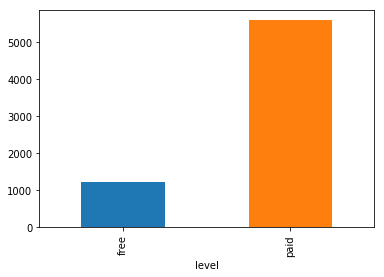

In [27]:
# Strict counts by level
df.groupby('level').count()['songplay_id'].plot(kind='bar')

Obviously, our paid users are utilizing the service much more than our free users.  But, what does the user count look like in each level?  Is one member, or several, driving those numbers?

In [29]:
users = df.groupby(['level', 'user_id']).nunique()['songplay_id'].sort_values(ascending=False)
users

level  user_id
paid   49         650
       80         648
       97         557
       15         462
       44         397
       29         341
       24         321
       73         289
       88         241
       36         241
       95         213
       16         208
       85         178
       30         178
       25         169
       58         140
       42         140
free   26         114
paid   82          87
       72          72
free   32          56
       101         55
       50          48
       86          45
       49          39
       66          37
       37          34
paid   70          33
free   88          29
       69          29
                 ... 
       84           6
       81           6
       18           5
       7            5
       29           5
       71           5
       13           5
       4            5
       5            4
       98           4
       23           4
       99           4
       47           3
       48        

### The When Breakdown

Any streaming service should understand if their service is being utilized more or less at different times of the day so they can allocate resources accordingly.

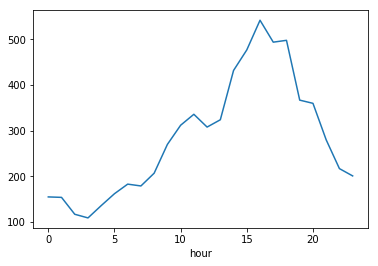

In [26]:
df.groupby('hour').count()['songplay_id'].plot(kind="line")

The service peaks with users listening to songs during the late-afternoon to early evening.

What about day of week?  Can we see any interesting trends?

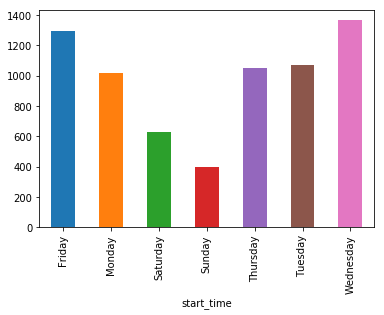

In [31]:
df.groupby(df['start_time'].dt.weekday_name).count()['songplay_id'].plot(kind='bar')

This is interesting:  the lowest activity we have is on Saturday and Sunday.